This is the Part-9 of the Deep Reinforcement Learning Notebook series. In this Notebook I have introduced Soft Actor-Critic (SAC).

The Notebook series is about Deep RL algorithms so it excludes all other techniques that can be used to learn functions in reinforcement learning and also the Notebook Series is not exhaustive i.e. it contains the most widely used Deep RL algorithms only.

**Images used in this notebook are taken from original SAC paper(Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor" by Haarnoja et al, 2018)**

##What is  Soft Actor-Critic (SAC)

Soft Actor-Critic (SAC) was introduced in "Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor" by Haarnoja et al, 2018.

Soft Actor-Critic (SAC) is policy maximum entropy actor-critic algorithm which provides for both sample- efficient learning and stability.This algorithm extends readily to very complex, high-dimensional tasks.

Soft Actor Critic (SAC) is an algorithm that optimizes a stochastic policy in an off-policy way, forming a bridge between stochastic policy optimization and DDPG-style approaches. It isn’t a direct successor to TD3 (having been published roughly concurrently), but it incorporates the clipped double-Q trick, and due to the inherent stochasticity of the policy in SAC, it also winds up benefiting from something like target policy smoothing.

A central feature of SAC is entropy regularization. The policy is trained to maximize a trade-off between expected return and entropy, a measure of randomness in the policy. This has a close connection to the exploration-exploitation trade-off: increasing entropy results in more exploration, which can accelerate learning later on. It can also prevent the policy from prematurely converging to a bad local optimum.
Soft actor-critic algorithm incorporates three key in- gredients: an actor-critic architecture with separate policy and value function networks, an off-policy formulation that enables reuse of previously collected data for efficiency, and entropy maximization to enable stability and exploration.

##Maximum Entropy Reinforcement Learning
Standard RL maximizes the expected sum of rewards 􏰏$\sum_tE_{(s_t,a_t)∼ρ_π} [r(s_t,a_t)]$. In SAC a more general maximum entropy objective(Equation-9.1) is used which favors stochastic policies by augmenting the objective with the expected entropy of the policy over $ρ_π(s_t)$.

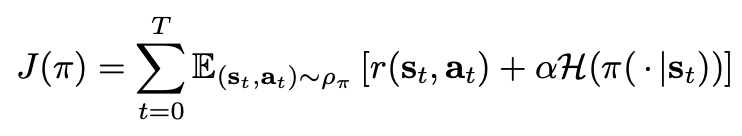

Equation-9.1

The temperature parameter α determines the relative importance of the entropy term against the reward, and thus controls the stochasticity of the optimal policy. In the paper α is omitted as it can always be subsumed into the reward by scaling it $α^{-1}$.

##Soft Q-value

Here is the Q-value in form of V-value that we already know.

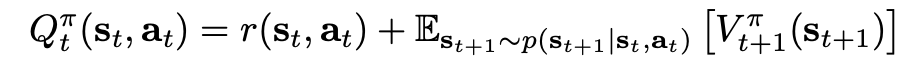

Now to convert it to soft-Q value we replace V like below:
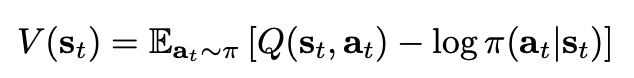

##Policy 

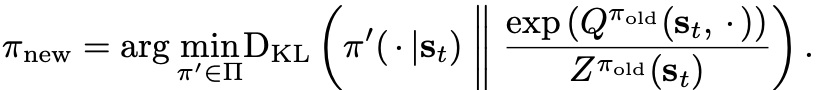

The partition function $Z^{π_{old}}(s_t)$ normalizes the distribution, and while it is intractable in general, it does not contribute to the gradient with respect to the new policy and can thus be ignored

##Training SAC

We will consider a parameterized state value function $V_ψ(s_t)$, soft Q-function $Q_θ(s_t,a_t)$, and a tractable policy $π_φ(a_t|s_t)$. The parameters of these networks are ψ, θ, and φ. For example, the value functions can be modeled as expressive neural networks, and the policy as a Gaussian with mean and covariance given by neural networks.

The soft value function objective and its gradient are show below in 
Equation 9.2 and Equation 9.3 respectively
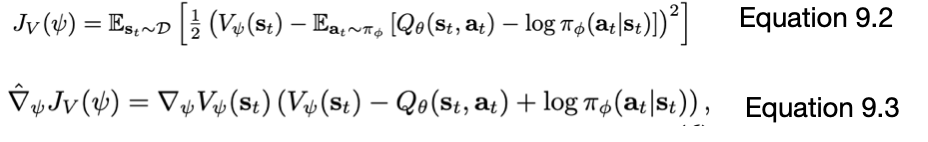

where D is the distribution of previously sampled states and
actions, or a replay buffer. T

The soft Q-value function objective and its gradient are show below in 
Equation 9.4 and Equation 9.5 respectively
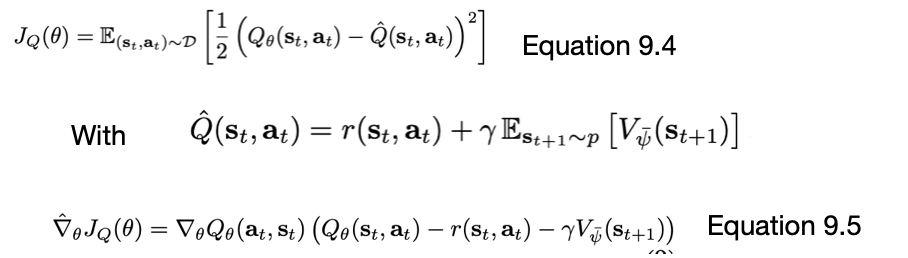

The traditonal way is that we used before in Reinforce and A2C i.e. using policy gradients. So the policy gradient for SAC is as follows:

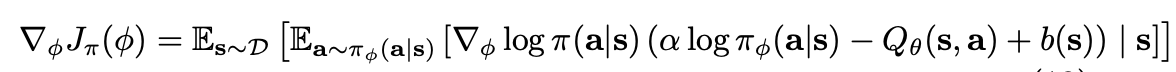

where b(s) is a baseline that you can choose freely. Again, you can estimate the outer expectation via a minibatch of N states from the replay buffer, and the inner expectation via a single-sample action from the policy. 

The another way is using Reparameterization trick. In reparameterization trick we suppose that the policy can be expressed as a = $f_φ$ (ε; s), where ε ∼ N (0, I).The policy objective and its gradient using are reparameterization trick  show below in Equation 9.6 and Equation 9.7 respectively .

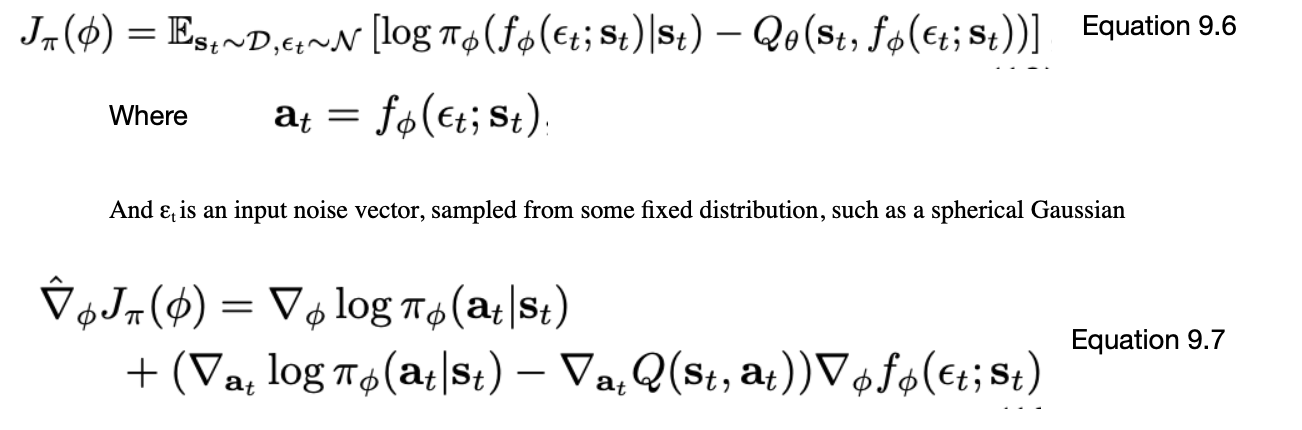

The expectation of the new loss function no longer depends on the policy parameters φ, but now the action a = $f_φ$(ε;s) is dependent on the policy parameters. Therefore, for the reparameterized loss we must make sure that the gradients of the sampled actions (w.r.t. the policy parameters) “flow” via backpropagation. By default, Tensorflow assumes that Gaussian distributions are reparameterized and will backpropagate the gradients of the actions. In the REINFORCE gradient estimator however, we treat the sampled actions as fixed constants, so we must disable the gradients of the policy from flowing through the actions. You will need to do this by adding a tf.stop_gradient op in GaussianPolicy right after sampling actions from the policy when reparameterization is disabled.



**Differences between Reinforce and Reparameterization**

(Taken from:http://stillbreeze.github.io/REINFORCE-vs-Reparameterization-trick/)

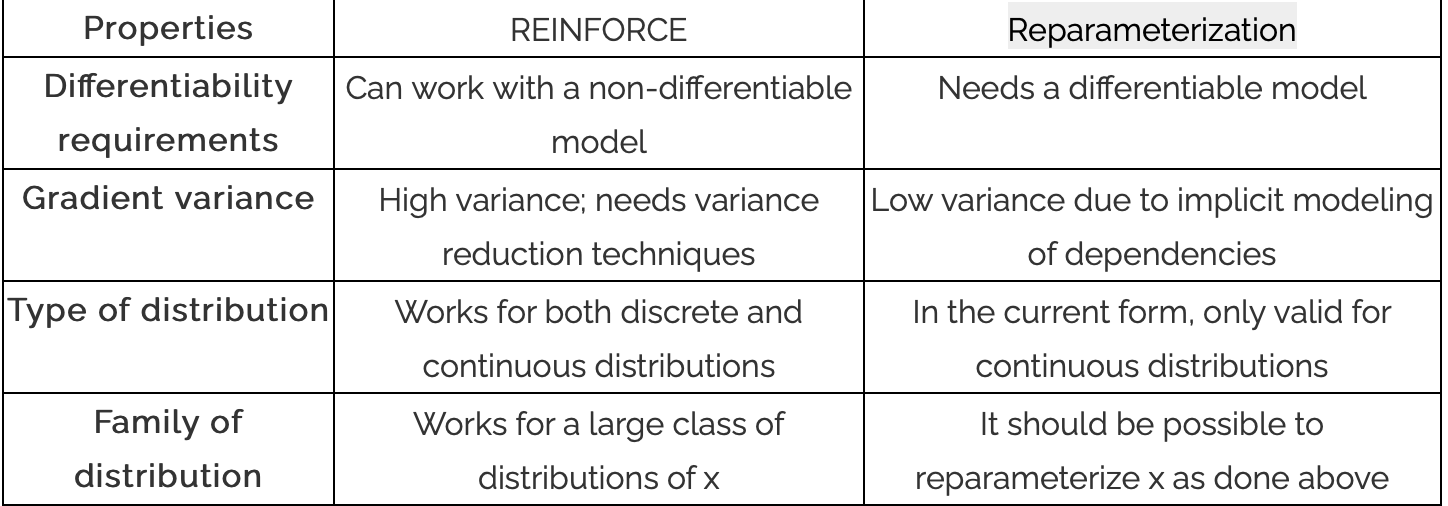


##SAC
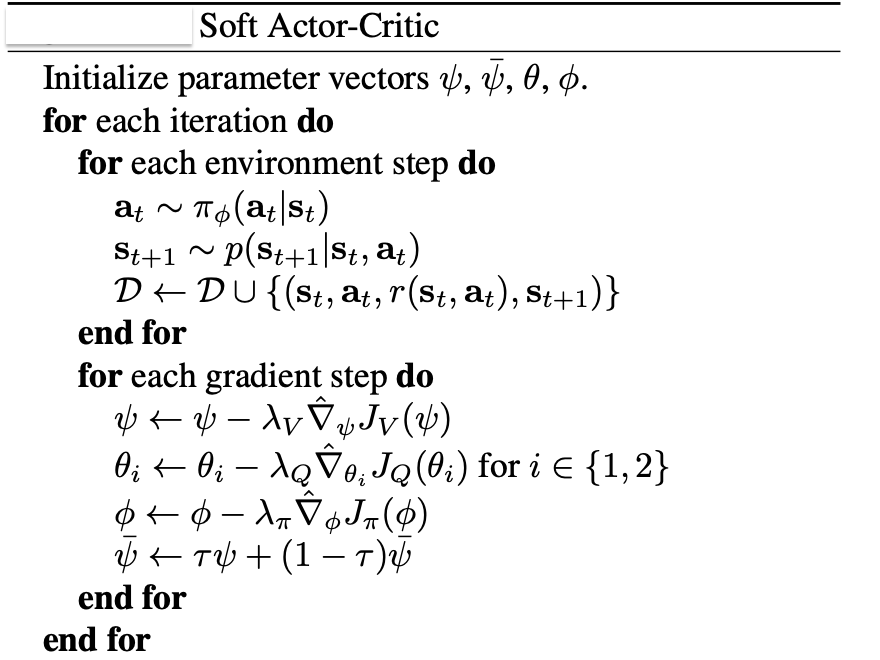

##Implementing SAC

Below code setups the environment required to run and record the game and also loads the required library.

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Concatenate
from tensorflow.keras.models import Sequential,load_model,Model
import gym
import numpy as np
import random
from collections import deque
from tensorflow.keras.utils import normalize as normal_values
import cv2
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import clear_output
from IPython import display as ipythondisplay
import tensorflow_probability as tfp

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

This part ensures the reproducibility of the code below by using a random seed and setups the environment.

In [ ]:
RANDOM_SEED=3
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
env = gym.make("HalfCheetah-v2")
#env=wrap_env(env)  #use this when you want to record a video of episodes
env.seed(RANDOM_SEED)
env.reset() # reset to env


num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Defining the GaussianPolicy Class. This is policy used to take actions. We can use Reinforce or Reparameterization by setting reparameterize parameter to false and true repectively.

In [ ]:
class GaussianPolicy():
  def __init__(self,action_dim,state_dim ,reparameterize):
    self.reparameterize = reparameterize
    self.action_dim=action_dim
    self.state_dim=state_dim
    self.model = self.create_model()

  def create_model(self):
    model=Sequential()
    model.add(Input(shape=(self.state_dim)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(self.action_dim * 2, activation=None))
    return model

  def call(self, inputs):
    mean_and_log_std = self.model(inputs)
    mean, log_std = tf.split(mean_and_log_std, num_or_size_splits=2, axis=1)
    log_std = tf.clip_by_value(log_std, -20., 2.)
    
    distribution = tfp.distributions.MultivariateNormalDiag(loc=mean,scale_diag=tf.exp(log_std))
    
    raw_actions = distribution.sample()
    if not self.reparameterize:
        raw_actions = tf.stop_gradient(raw_actions)
    log_probs = distribution.log_prob(raw_actions)
    log_probs -= self._squash_correction(raw_actions)

    self.actions = tf.tanh(raw_actions)
    
    return self.actions, log_probs
    
  def _squash_correction(self, raw_actions, stable=True, eps=1e-8):
    if not stable:
      return tf.reduce_sum(tf.math.log(1. - tf.square(tf.tanh(raw_actions)) + eps), axis=1)
    else:
      return tf.reduce_sum(tf.math.log(4.) + 2. * (raw_actions - tf.nn.softplus(2. * raw_actions)), axis=1)

  def eval(self, state):
        
    action, _ = self.model(state)
    return action.flatten()

Defining the SAC Class. At initiation, the SAC object sets a few parameters like environment, action and state space,create Q_function,target_Q_function,V_function and policy models,and remember(that records the observations of each step.)

In [ ]:
class SAC:
 
  def __init__(self,upper_bound,lower_bound,buffer_capacity=50000,observing_episodes=1,alpha=0.05,reparameterize=False,p_1=None,p_2=None,p_3=None,p_4=None,p_5=None):
    self.upper_bound=upper_bound
    self.lower_bound=lower_bound
    self.observing_episodes=observing_episodes
    self.state_shape=env.observation_space.shape[0] # the state space
    self.action_shape=env.action_space.shape[0] # the action space
    self.gamma=[0.99] # decay rate of past observations
    self.learning_rate_Q_function= 3e-4
    self.learning_rate_V_function= 3e-4 
    self.learning_rate_policy= 3e-4
    self.reparameterize=reparameterize
    self.tau=0.01
    self.alpha=alpha
    self.epsilon=1.0
    self.batch_size=256
    self.index=0
    self.beta=0.001 
    if not p_1:
      self.Q_function=self._create_model('Q_function')    
      self.target_Q_function=self._create_model('Q_function')
      self.V_function=self._create_model('V_function')
      self.policy=self._create_model('Policy')  
    else:
      self.Q_function=load_model(p_1)    
      self.target_Q_function=load_model(p_2)
      self.V_function=load_model(p_3)
      self.target_V_function=load_model(p_4)
      self.policy=GaussianPolicy(self.action_shape,self.state_shape,self.reparameterize,p_5)
    
    self.buffer_capacity = buffer_capacity
    self.buffer_counter = 0

    self.states=np.zeros((self.buffer_capacity, self.state_shape))
    self.rewards=np.zeros((self.buffer_capacity,1))
    self.dones=np.zeros((self.buffer_capacity, 1))
    self.actions=np.zeros((self.buffer_capacity, 6))
    self.next_states=np.zeros((self.buffer_capacity, self.state_shape))
  
  def remember(self, state, reward,action,next_state,done):
    '''stores observations'''
    self.index = self.buffer_counter % self.buffer_capacity
    self.rewards_plot.append(reward)
    self.states_plot.append(state)
    self.actions_plot.append(action)
    self.states[self.index] = state
    self.rewards[self.index]=reward
    self.dones[self.index]=done
    self.actions[self.index]=action
    self.next_states[self.index]=next_state
    self.buffer_counter += 1

Creating a Neural Network Model (Q_function,target_Q_function,V_function and policy)

In [ ]:
  def _create_model(self,model_type):
 
    ''' builds the model using keras'''
 
    state_input = Input(shape=(17,))
  
    layer_1=(Dense(256, activation="relu"))(state_input)  
    layer_2=(Dense(256, activation="relu"))(layer_1)
 
    if model_type=='Q_function':
      action_input = Input(shape=(self.action_shape))
      action_layer_1 = Dense(128, activation="relu")(action_input)
      

      concat = Concatenate()([layer_2,action_layer_1])
      concat_layer_1=Dense(256,activation="relu")(concat)

      output = Dense(1, activation=None)(concat_layer_1)

      model = Model(inputs=[state_input,action_input],outputs=[output])

    elif model_type=='V_function':
      output = Dense(1, activation=None)(layer_2)
      model = Model(inputs=[state_input],outputs=[output])
    else:
      model=GaussianPolicy(self.action_shape,self.state_shape,self.reparameterize)
    return model

Action Selection

The get_action method guides the action choice. 

It uses ∊-greedy policy for choosing the action. Initially, since the value of ∊ is high agent choose randomly but later in training the agent chooses the actions from the policy. 

After choosing an action we bound it to ensure it stays in legal actions of the environment

In [ ]:
  def get_action(self, state,status="Training"):
    '''samples the next action based on the policy probabilty distribution 
      of the actions'''
    if random.random() > self.epsilon:
      action,_ = self.policy.call(state)
    else:
      action=(np.random.uniform(-1, 1, self.action_shape))
      
    action=action*self.upper_bound
    legal_action = np.clip(action, self.lower_bound, self.upper_bound)
    return legal_action

Next comes the three losses: Policy Loss, V_function loss and Q_function loss.

In [ ]:
  def policy_loss(self,states):
    if not self.reparameterize:
      actions, log_pis = self.policy.call(states)
      actions=actions*self.upper_bound
      actions=np.clip(actions, self.lower_bound, self.upper_bound)
      if self.target_Q_function is None:
        q_n = tf.squeeze(self.Q_function((states, actions)), axis=1)
      else:
        q_n = tf.minimum(tf.squeeze(self.Q_function((states, actions)), axis=1),tf.squeeze(self.target_Q_function((states, actions)), axis=1))                
        b_n = tf.squeeze(self.V_function(states), axis=1)
        policy_loss = tf.reduce_mean(log_pis * tf.stop_gradient(self.alpha * log_pis - q_n + b_n))
    else:
      actions, log_pis = self.policy.call(states)
      actions=actions*self.upper_bound
      actions=np.clip(actions, self.lower_bound, self.upper_bound)
      if self.target_Q_function is None:
        q_n = tf.squeeze(self.Q_function((states, actions)), axis=1)
      else:
        q_n = tf.minimum(tf.squeeze(self.Q_function((states, actions)), axis=1),tf.squeeze(self.target_Q_function((states, actions)), axis=1))                
        b_n = tf.squeeze(self.V_function(states), axis=1)
        policy_loss = tf.reduce_mean(self.alpha * log_pis - q_n+b_n)
    return policy_loss
  
  def value_function_loss(self, states):
    actions, log_pis = self.policy.call(states)
    actions=actions*self.upper_bound
    actions=np.clip(actions, self.lower_bound, self.upper_bound)
    if self.target_Q_function is None:
      q_n = tf.squeeze(self.Q_function((states, actions)), axis=1)
    else:
      q_n = tf.minimum(tf.squeeze(self.Q_function((states, actions)), axis=1),tf.squeeze(self.target_Q_function((states, actions)), axis=1)) 
      v_n = tf.squeeze(self.V_function(states), axis=1)
      value_function_loss = tf.reduce_mean(tf.losses.mean_squared_error(q_n - self.alpha * log_pis,v_n))
    return value_function_loss
    
  def q_function_loss(self, states,next_states,actions,dones,rewards):
    q_n = tf.squeeze(self.Q_function((states, actions)), axis=1)
    next_v_n = tf.squeeze(self.V_function(next_states), axis=1)
    q_function_loss = tf.reduce_mean(tf.losses.mean_squared_error(rewards + (1 - dones) * self.gamma * next_v_n,q_n))
    return q_function_loss 

Updating networks

We update V_function,Q_function and policy according to their respective loss that we discussed earlier and do soft updates on target Q network.

In [ ]:
  def update_models(self):
    '''
    Updates the network.
    '''
    record_range = min(self.buffer_counter, self.buffer_capacity)
    batch_indices = np.random.choice(record_range,self.batch_size)

    states_mb=self.states[batch_indices]
    actions_mb=self.actions[batch_indices]
    next_states_mb=self.next_states[batch_indices]
    rewards_mb=self.rewards[batch_indices]
    dones_mb=self.dones[batch_indices]

    optimizer_Q_function = tf.keras.optimizers.Adam(learning_rate=self.learning_rate_Q_function)
    optimizer_V_function = tf.keras.optimizers.Adam(learning_rate=self.learning_rate_V_function)
    optimizer_policy = tf.keras.optimizers.Adam(learning_rate=self.learning_rate_policy)
    

    def train_Q_function(states,next_states,actions,dones,rewards):
      with tf.GradientTape() as tape:
        Q_function_loss=self.q_function_loss(states,next_states,actions,dones,rewards)
        print("Q Function Loss:",Q_function_loss)
      grads = tape.gradient(Q_function_loss,self.Q_function.trainable_variables)
      optimizer_Q_function.apply_gradients(zip(grads, self.Q_function.trainable_variables))
    train_Q_function(states_mb,next_states_mb,actions_mb,dones_mb,rewards_mb)
    

    def train_V_function(states):
      with tf.GradientTape() as tape:
        V_function_loss=self.value_function_loss(states)
        print("V Function Loss:",V_function_loss)
      grads = tape.gradient(V_function_loss,self.V_function.trainable_variables)
      optimizer_V_function.apply_gradients(zip(grads, self.V_function.trainable_variables))
    train_V_function(states_mb)
    

    def train_policy(states):
      with tf.GradientTape() as tape:
        Policy_loss=self.policy_loss(states)
        print("Policy Loss:",Policy_loss)
      grads = tape.gradient(Policy_loss,self.policy.model.trainable_variables)
      optimizer_policy.apply_gradients(zip(grads, self.policy.model.trainable_variables))
    train_policy(states_mb)
    

    Q_function_weights = np.array(self.Q_function.get_weights())
    Q_function_target_weights = np.array(self.target_Q_function.get_weights())
    Q_function_target_new_weights = self.tau*Q_function_weights + (1-self.tau)*Q_function_target_weights
    self.target_Q_function.set_weights(Q_function_target_new_weights)

Training the model

This method creates a training environment for the model. Iterating through a set number of episodes, it uses the model to sample actions and play them. When such a sequence ends, the model is using the recorded observations to update the policy.

In [ ]:
  def train(self,episodes):
    ep_reward_list=[]
    c=0
    x=0
    for episode in range(episodes):
      env = (gym.make("HalfCheetah-v2"))
      aList=list(range(100))
      seed=(random.sample(aList, 1))[0]
      #print("Seed selected:{}".format(seed))
      env.seed(seed)
      state_=env.reset().reshape((1,17))
      done=False
      episode_reward=0  #record episode reward
      while not done:
        action=self.get_action(state_)
        next_state, reward, done, info=env.step(action)
        next_state_=next_state.reshape((1,17))
        self.remember(state_,reward,action,next_state_,done)
        state_ = next_state_
        episode_reward+=reward
      print('Updating the models')
      self.update_models()
      if self.epsilon > 0.001:
        self.epsilon=self.epsilon-0.001
      ep_reward_list.append(episode_reward)
      avg_reward = np.mean(ep_reward_list[-40:])
      print("Episode:{}  Reward:{} Exploration_value:{} Average_reward:{}".format(episode,episode_reward,self.epsilon,avg_reward))
      if episode%100==0 and episode!=0:
        self.Q_function.save('Q_model_{}.h5'.format(episode))  
        self.target_Q_function.save('target_Q_model_{}.h5'.format(episode))
        self.V_function.save('V_model_{}.h5'.format(episode))  
        self.policy.model.save('policy_{}.h5'.format(episode))  

In [ ]:
Agent=SAC(upper_bound,lower_bound,reparameterize=True)
Agent.train(1101)

##Tip for imporving SAC performance: 
Try reward scaling. According to authors of the paper SAC improves a lot with fine tuning of reward scaling